In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm

from itertools import permutations
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts import TimeSeries
from darts.models import NLinearModel
from darts.metrics import mape, mae, rmse


## Functions

In [3]:
## read data
def get_timeseries (filepath):
    electricity_consumption = pd.read_csv(filepath)
    # Convert dataframe to Timeseries
    ts = TimeSeries.from_dataframe(electricity_consumption, time_col="Date" )
    return ts



In [4]:
def eval_model(model, full_data,val_target, DESC):
    pred_series = model.predict(n=42)[DESC]
    plt.figure(figsize=(8, 5))
    full_data[DESC].plot(label="actual")
    pred_series[DESC].plot(label="forecast")
    plt.title("Seasonal Naive Bayes Model: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val_target, pred_series), mae(val_target, pred_series), mape(val_target, pred_series)))
    plt.legend()
    return pred_series

In [5]:
def Nlinear_tuning(train_data, val_target, DESC, past_covariates=None):
    input_lim = len(train_data) - 42 # 42 is the number of forecasted values
    best_param, best_mape = 0, 100
    best_cov = ""
    for i in range(18, input_lim):
        model = NLinearModel(
            input_chunk_length=i,
            output_chunk_length=42,
            n_epochs=200, 
            pl_trainer_kwargs = pl_trainer_kwargs)
        for j in past_covariates:
            model.fit(train_data[DESC], past_covariates=train_data[list(j)], val_series = val_target[DESC])
            pred = model.predict(n=42, past_covariates=train_data[list(j)])[DESC]
            mape_score = mape(val_target[DESC], pred)
            if mape_score < best_mape:
                best_param = i
                best_mape = mape_score
                best_cov = j

    return best_param, best_mape

In [6]:
def past_covariance_perm(feature_list):
    return_list = []
    for i in range(1,len(feature_list)+1):
        return_list.extend(list(permutations(feature_list,i)))
    return return_list

    

In [7]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [8]:
file_list_name = ['Electricity-ResBusClimateUNI.csv', 'Electricity-ResBusClimateCNI.csv', 
                  'Electricity-ResBusClimateLNI.csv', 'Electricity-ResBusClimateUSI.csv', 'Electricity-ResBusClimateLSI.csv']
path_name = '../AnalysisAndPreprocessing/ProcessedData_Original/'
timeseries_list = [get_timeseries(path_name + file) for file in file_list_name]


# Residential Data

In [296]:
residential_metrics = pd.DataFrame(columns=['RMSE', 'MAE', 'MAPE', 'Zone'])

In [374]:
TRYINGDLINEAR = timeseries_list[0]
train, val= TRYINGDLINEAR.split_after(pd.Timestamp('2021-01-01'))


In [375]:
train.columns


Index(['Total Rainfall Mm', 'Mean Air Temperature in Celsius',
       'Mean Vapour Pressure Hpa', 'Mean Wind Speed M/Sec',
       'Days Of Wind Gust >= 24 Knots in Day',
       'Standard Deviation Of Daily Mean Temperature in Celsius', 'Year',
       'Month', 'Selected business demand (GWh)',
       'Est. Total consumption (GWh)', 'Export prices', 'Export volumes',
       'Export values', 'Import prices', 'Import volumes', 'Import values',
       'Population'],
      dtype='object', name='component')

In [376]:
past_cov = ['Mean Air Temperature in Celsius', 'Days Of Wind Gust >= 24 Knots in Day', 'Total Rainfall Mm',]

In [377]:
desc = 'Est. Total consumption (GWh)'

In [378]:
my_stopper = EarlyStopping(
    monitor="val_loss",
    patience=12,
    min_delta=0.05,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper]}

In [379]:
param_grid = {
     'input_chunk_length': [i for i in range(12, 28)],
     'output_chunk_length': [12],
     'n_epochs': [200],
     }

model = NLinearModel(
     input_chunk_length=25,
     output_chunk_length= 12,
     n_epochs=200,
     pl_trainer_kwargs = None)




In [380]:
model.fit(train[desc], past_covariates=train[past_cov], val_series=val[desc], val_past_covariates = val[past_cov] )

ValueError: The provided validation time series dataset is too short for obtaining even one training point.

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Date'>

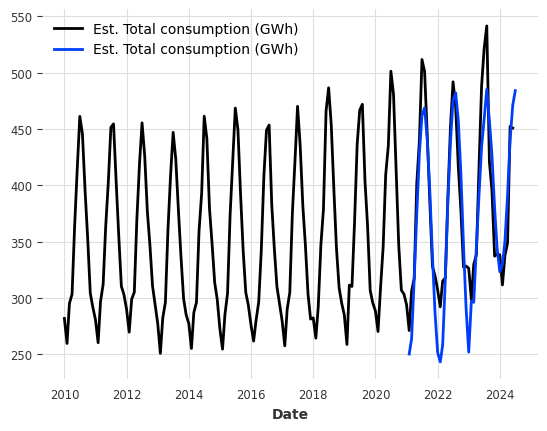

In [373]:
TRYINGDLINEAR[desc].plot()
model.predict(n=42, past_covariates = TRYINGDLINEAR[past_cov]).plot()


In [362]:
i = model.gridsearch(parameters = param_grid, 
                 series=train[desc], 
                 val_series=val[desc],
                 metric=mape,
                 verbose=True,
                 n_jobs = 4)


  0%|          | 0/16 [00:00<?, ?it/s]

In [370]:
i[1]

{'input_chunk_length': 25, 'output_chunk_length': 12, 'n_epochs': 200}

In [304]:
past_list = past_covariance_perm(past_cov)


('Mean Air Temperature in Celsius', 'Total Rainfall Mm')

In [308]:
Nlinear_tuning(train, val, 'Est. Total consumption (GWh)', past_covariates=past_list)

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 136.21it/s, train_loss=2.86e+4]

RuntimeError: Early stopping conditioned on metric `val_loss` which is not available. Pass in or modify your `EarlyStopping` callback to use any of the following: `train_loss`

In [32]:
desc = 'Est. Total consumption (GWh)'

In [270]:
model = NLinearModel(
     input_chunk_length=19,
     output_chunk_length=42,
     n_epochs=200)

In [271]:
model.fit(train[desc], past_covariates=train[past_cov])

Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 157.91it/s, train_loss=463.0]  


NLinearModel(output_chunk_shift=0, shared_weights=False, const_init=True, normalize=False, use_static_covariates=True, input_chunk_length=19, output_chunk_length=42, n_epochs=200)

<Axes: xlabel='Date'>

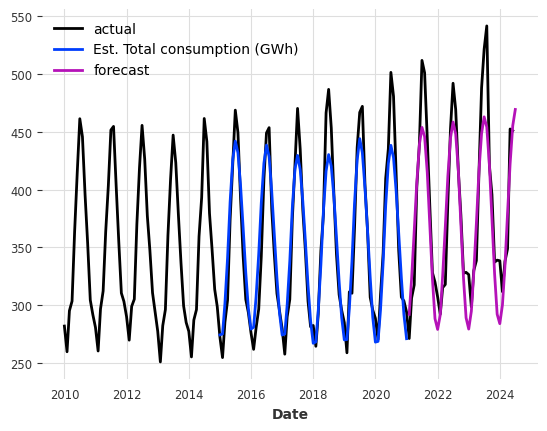

In [279]:
TRYINGDLINEAR[desc].plot(label="actual")
i.plot()
pred.plot(label="forecast")

In [280]:
model.backtest(series=TRYINGDLINEAR[desc], start=pd.Timestamp('2021-01-01'), forecast_horizon=42, retrain=False, past_covariates=TRYINGDLINEAR[past_cov], historical_forecasts=i, last_points_only=True)

4.928574793653139

In [185]:
pred = model.predict(42, past_covariates=train[past_cov])

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.38it/s]


<Axes: xlabel='Date'>

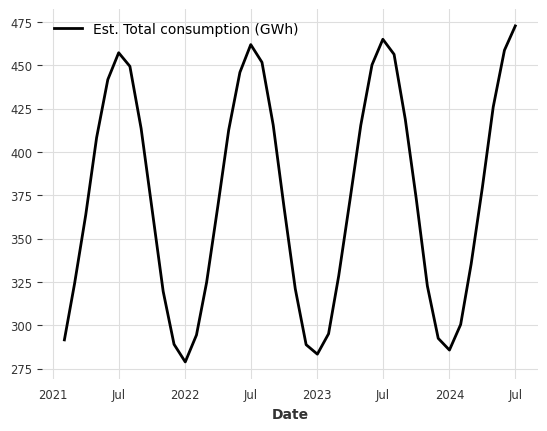

In [186]:
pred[desc].plot()

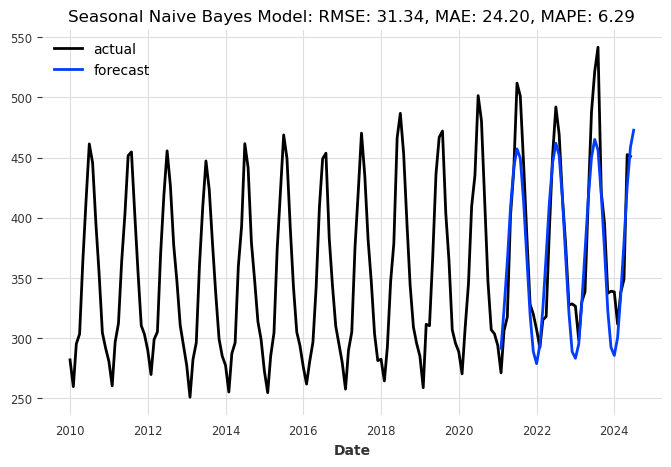

In [187]:
plt.figure(figsize=(8, 5))
TRYINGDLINEAR[desc].plot(label="actual")
pred[desc].plot(label="forecast")
plt.title("Seasonal Naive Bayes Model: RMSE: {:.2f}, MAE: {:.2f}, MAPE: {:.2f}".format(rmse(val[desc], pred), mae(val[desc], pred), mape(val[desc], pred)))
plt.legend()

In [20]:
pred = model.predict()
pred.values()

ValueError: For the given forecasting horizon `n=7`, the provided past covariates at dataset index `0` do not extend far enough into the future. As `n > output_chunk_length` the past covariates must end at time step `2021-02-01 00:00:00`, whereas now they end at time step `2021-01-01 00:00:00`.

In [16]:

pred_series = eval_model(model, TRYINGDLINEAR, val['Est. Total consumption (GWh)'], 'Est. Total consumption (GWh)')


ValueError: For the given forecasting horizon `n=42`, the provided past covariates at dataset index `0` do not extend far enough into the future. As `n > output_chunk_length` the past covariates must end at time step `2024-01-01 00:00:00`, whereas now they end at time step `2021-01-01 00:00:00`.

In [ ]:


target = series['p (mbar)'][:100]
# optionally, use past observed rainfall (pretending to be unknown beyond index 100)
past_cov = series['rain (mm)'][:100]
# optionally, use future temperatures (pretending this component is a forecast)
future_cov = series['T (degC)'][:106]
# predict 6 pressure values using the 12 past values of pressure and rainfall, as well as the 6 temperature
# values corresponding to the forecasted period

model.fit(target, past_covariates=past_cov, future_covariates=future_cov)
pred = model.predict(6)
pred.values()


In [ ]:

# Initialize the DLinearModel
model = DLinearModel(input_chunk_length=24, output_chunk_length=12, kernel_size=25, random_state=42)

# Fit the model
model.fit(TRYINGDLINEAR[''])

# Forecast future values
forecast = model.predict(n=len(test))
forecast = scaler.inverse_transform(forecast)

# Evaluate the performance
error = mae(test, forecast)
print(f'Mean Absolute Error: {error:.4f}')

# Plot results
series.plot(label='actual')
forecast.plot(label='forecast', color='red')



Electricity-ResBusClimateUNI.csv
Electricity-ResBusClimateCNI.csv
Electricity-ResBusClimateLNI.csv
Electricity-ResBusClimateUSI.csv
Electricity-ResBusClimateLSI.csv


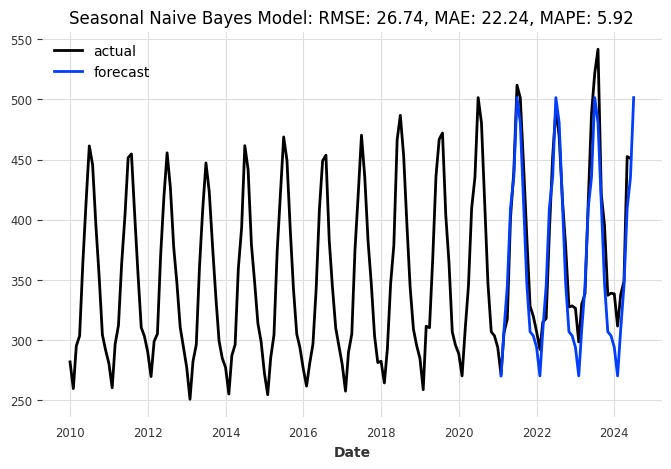

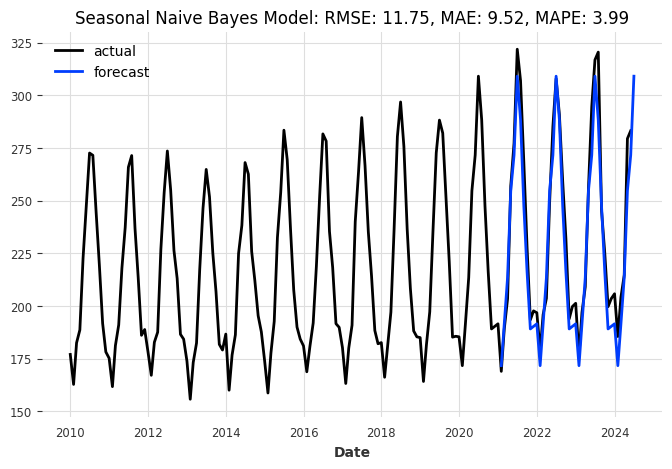

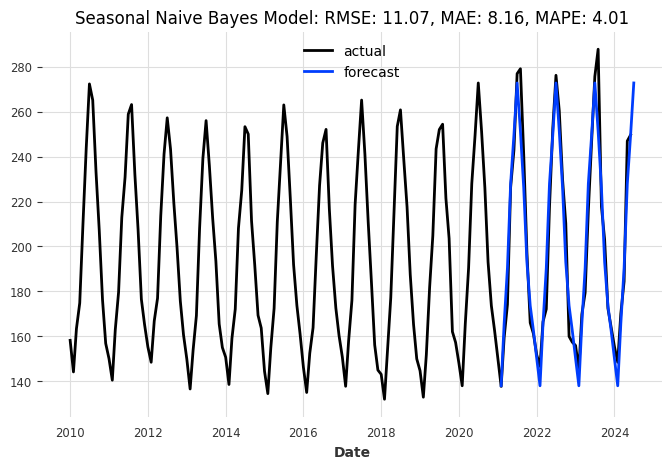

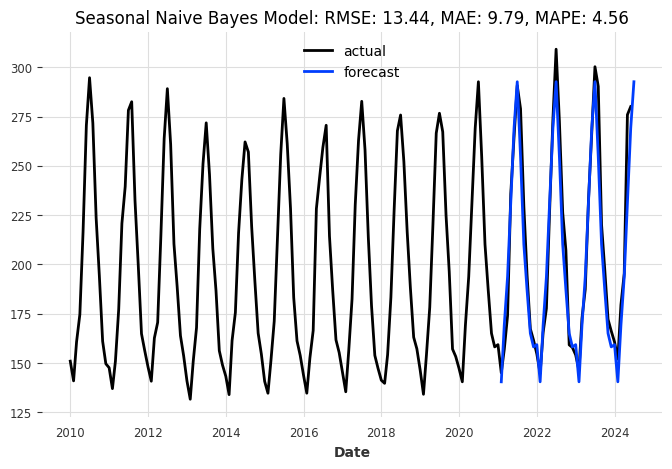

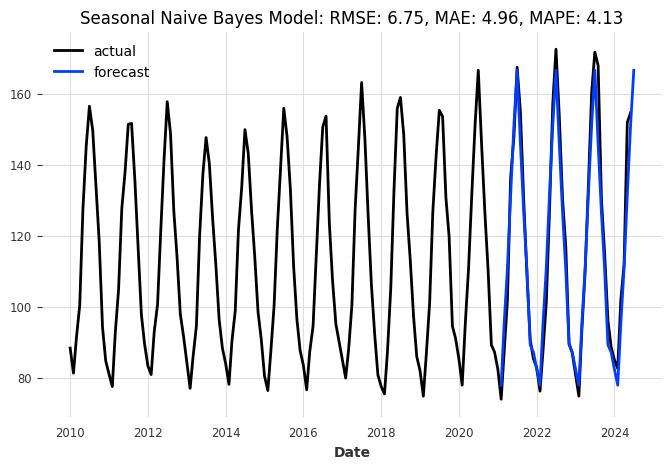

In [7]:
Electricity_Type = 'Est. Total consumption (GWh)'

zone_names = ['UNI', 'CNI', 'LNI', 'USI', 'LSI']
for i in range(len(timeseries_list)):
    print(file_list_name[i])
    train, val = timeseries_list[i].split_after(pd.Timestamp('2021-01-01'))
    naive_model = NaiveSeasonal(K=12)
    naive_model.fit(train)
    ypred = eval_model(naive_model, timeseries_list[i], val[Electricity_Type], Electricity_Type)
    residential_metrics.loc[len(residential_metrics.index)] = [rmse(val[Electricity_Type], ypred), 
                                                               mae(val[Electricity_Type], ypred), 
                                                               mape(val[Electricity_Type], ypred), 
                                                                zone_names[i]]
    

In [8]:
residential_metrics

,RMSE,MAE,MAPE,Zone
0,26.738480,22.241610,5.922268,UNI
1,11.749833,9.520878,3.987598,CNI
2,11.066676,8.156341,4.011009,LNI
3,13.441925,9.786561,4.558953,USI
4,6.751599,4.964854,4.133973,LSI


# Business data

In [9]:
business_metrics = pd.DataFrame(columns=['RMSE', 'MAE', 'MAPE', 'Zone'])

Electricity-ResBusClimateUNI.csv
Electricity-ResBusClimateCNI.csv
Electricity-ResBusClimateLNI.csv
Electricity-ResBusClimateUSI.csv
Electricity-ResBusClimateLSI.csv


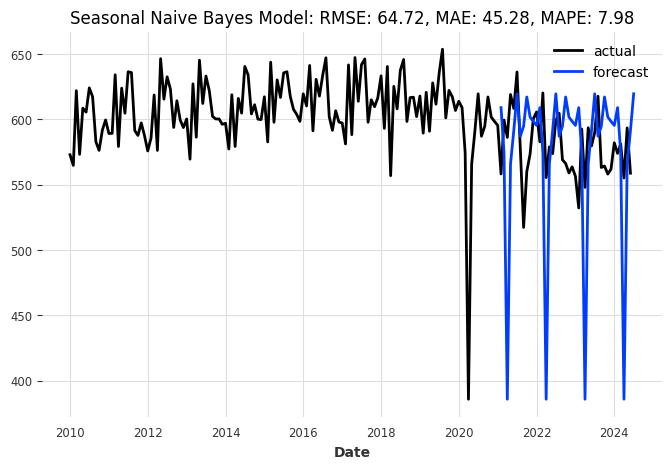

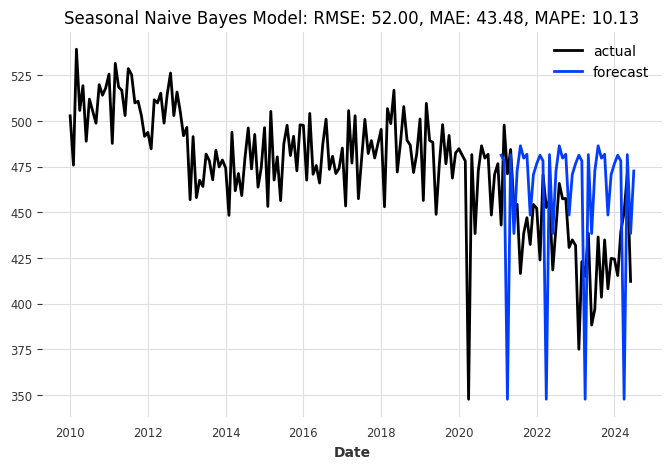

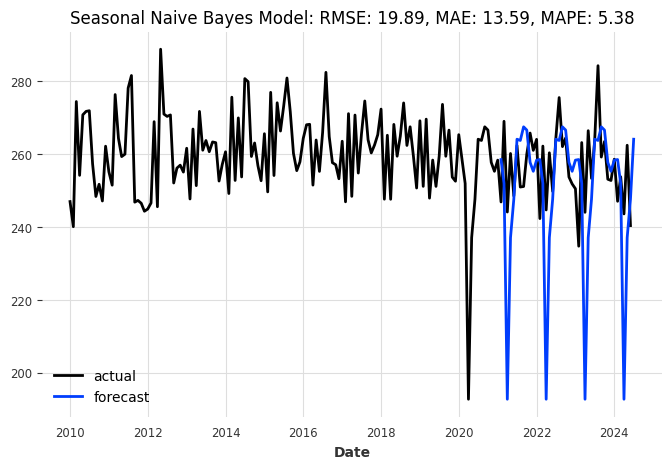

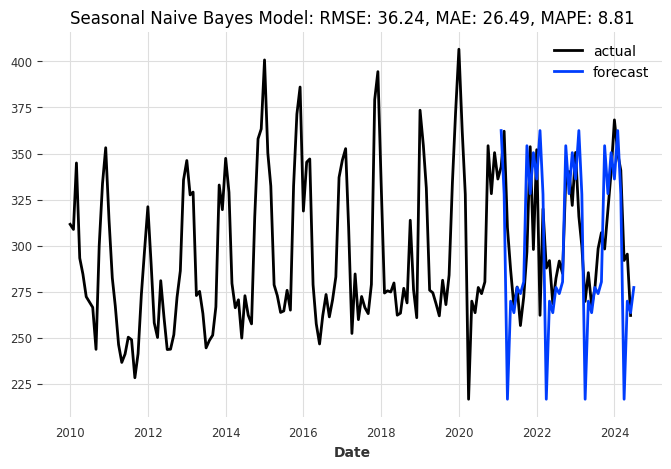

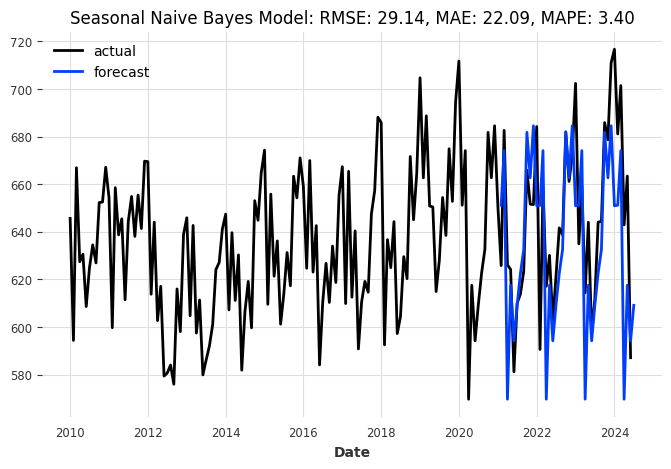

In [10]:
Electricity_Type = 'Selected business demand (GWh)'

for i in range(len(timeseries_list)):
    print(file_list_name[i])
    train, val = timeseries_list[i].split_after(pd.Timestamp('2021-01-01'))
    naive_model = NaiveSeasonal(K=12)
    naive_model.fit(train)
    ypred = eval_model(naive_model, timeseries_list[i], val[Electricity_Type], Electricity_Type)
    business_metrics.loc[len(business_metrics.index)] = [rmse(val[Electricity_Type], ypred), 
                                                               mae(val[Electricity_Type], ypred), 
                                                               mape(val[Electricity_Type], ypred), 
                                                                zone_names[i]]


In [11]:
business_metrics

,RMSE,MAE,MAPE,Zone
0,64.722832,45.279463,7.977740,UNI
1,52.002156,43.475049,10.130610,CNI
2,19.886841,13.586000,5.379352,LNI
3,36.236983,26.494415,8.805937,USI
4,29.143107,22.088488,3.402798,LSI


In [12]:
file_list_name = ['Electricity-ResBusClimateUNI.csv', 'Electricity-ResBusClimateCNI.csv', 
                  'Electricity-ResBusClimateLNI.csv', 'Electricity-ResBusClimateUSI.csv', 'Electricity-ResBusClimateLSI.csv']
path_name = '../AnalysisAndPreprocessing/ProcessedData_2020-04_Adjusted/'
timeseries_list = [get_timeseries(path_name + file) for file in file_list_name]


In [13]:
business_metrics_adjusted = pd.DataFrame(columns=['RMSE', 'MAE', 'MAPE', 'Zone'])

Electricity-ResBusClimateUNI.csv
Electricity-ResBusClimateCNI.csv
Electricity-ResBusClimateLNI.csv
Electricity-ResBusClimateUSI.csv
Electricity-ResBusClimateLSI.csv


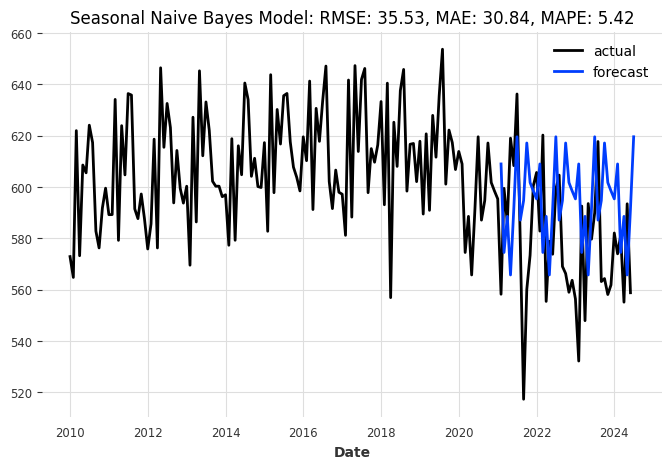

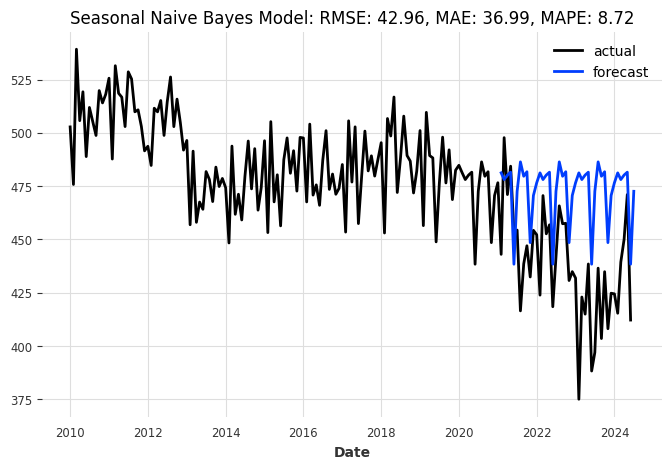

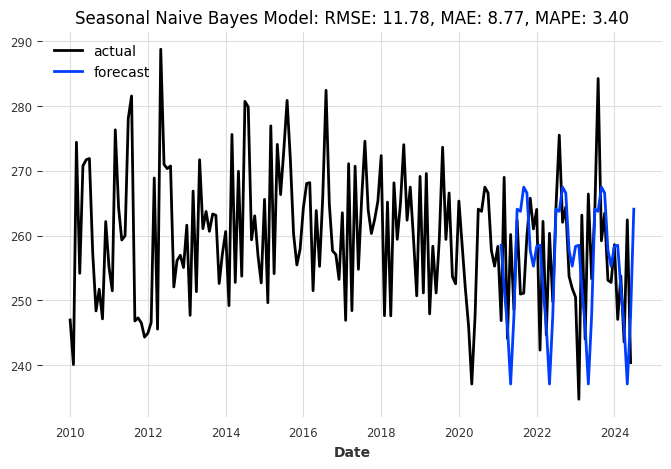

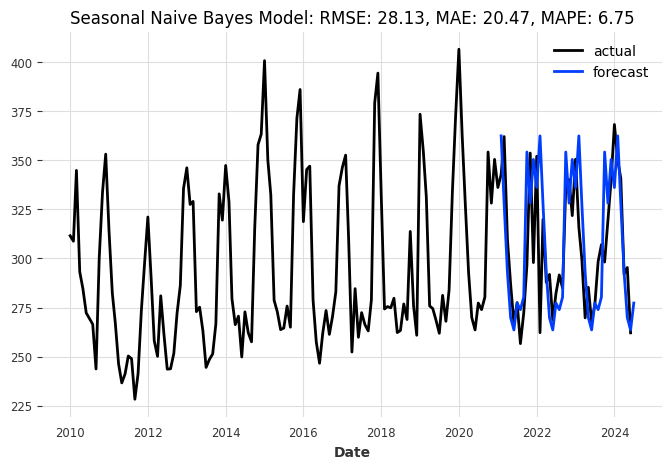

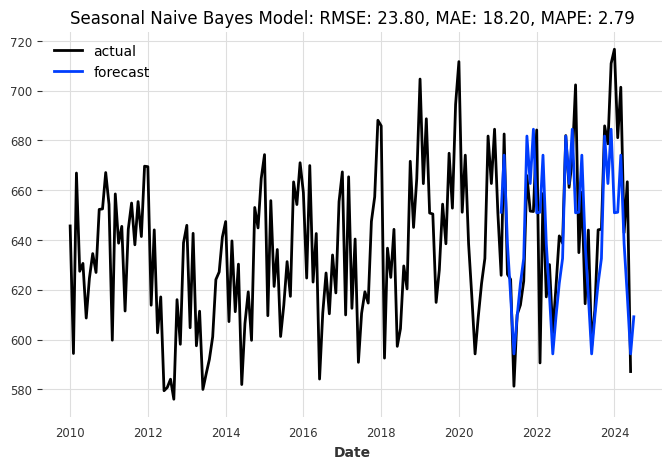

In [14]:
for i in range(len(timeseries_list)):
    print(file_list_name[i])
    train, val = timeseries_list[i].split_after(pd.Timestamp('2021-01-01'))
    naive_model = NaiveSeasonal(K=12)
    naive_model.fit(train)
    ypred = eval_model(naive_model, timeseries_list[i], val['Selected business demand (GWh)'], 'Selected business demand (GWh)')
    business_metrics_adjusted.loc[len(business_metrics_adjusted.index)] = [rmse(val['Selected business demand (GWh)'], ypred), 
                                                               mae(val['Selected business demand (GWh)'], ypred), 
                                                               mape(val['Selected business demand (GWh)'], ypred), 
                                                                zone_names[i]]


In [15]:
business_metrics_adjusted

,RMSE,MAE,MAPE,Zone
0,35.532342,30.843805,5.416914,UNI
1,42.958476,36.992561,8.719316,CNI
2,11.782911,8.765024,3.404391,LNI
3,28.126676,20.470634,6.750590,USI
4,23.803245,18.195390,2.785042,LSI
